# Initialization

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns


## read and prepare data

In [2]:
df = pd.read_excel(r'sc2 unit stats.xlsx')


In [3]:
df = df.replace('-', np.nan)

In [4]:
df.rename(columns=lambda x: x.replace(' ','_'), inplace=True)

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unit           73 non-null     object 
 1   Tier           61 non-null     object 
 2   Race           73 non-null     object 
 3   Supply         60 non-null     float64
 4   Minerals       67 non-null     float64
 5   Gas            65 non-null     float64
 6   Building_time  71 non-null     object 
 7   Size           73 non-null     object 
 8   Cargo          40 non-null     float64
 9   Armor          73 non-null     object 
 10  HP             73 non-null     object 
 11  Shields        73 non-null     int64  
 12  Attribut       73 non-null     object 
 13  Ground_attack  53 non-null     object 
 14  Air_attack     25 non-null     object 
 15  Bonus          28 non-null     object 
 16  Ground_DPS     53 non-null     object 
 17  Air_DPS        26 non-null     object 
 18  Bonus_DPS   

In [6]:
for column in ['HP', 'Armor', 'Ground_DPS', 'Air_DPS']:
    print(column)
    for i in df[column].index:
        value = df[column][i]
        # catch values str like '45 (+10)', but not int 45
        if type(value) is str:
            base = float(value.split('(')[0])
            bonus = float(value[value.find('(')+1 : value.find(')')])
            print(f'{value} -> {base}, {bonus}')
            df.at[i, column] = base
            df.at[i, column+'_bonus'] = bonus
    print(df[column].unique())
    print(df[column+'_bonus'].unique())

HP
30 (+5) -> 30.0, 5.0
[20 100 40 80 70 10 200 120 150 300 350 45 60 55 125 90 135 175 400 180
 140 550 1500 250 25 35 30.0 145 160 50 500 5 225]
[nan  5.]
Armor
0 (+1) -> 0.0, 1.0
1 (+1) -> 1.0, 1.0
1 (+1) -> 1.0, 1.0
1 (+1) -> 1.0, 1.0
1 (+1) -> 1.0, 1.0
0 (+1) -> 0.0, 1.0
1 (+1) -> 1.0, 1.0
0 (+1) -> 0.0, 1.0
0 (+1) -> 0.0, 1.0
0 (+1) -> 0.0, 1.0
1 (+1) -> 1.0, 1.0
1 (+1) -> 1.0, 1.0
1 (+1) -> 1.0, 1.0
0 (+1) -> 0.0, 1.0
0 (+1) -> 0.0, 1.0
0 (+1) -> 0.0, 1.0
2 (+1) -> 2.0, 1.0
2 (+1) -> 2.0, 1.0
0 (+1) -> 0.0, 1.0
2 (+1) -> 2.0, 1.0
0 (+1) -> 0.0, 1.0
0 (+1) -> 0.0, 1.0
0 (+1) -> 0.0, 1.0
0 (+1) -> 0.0, 1.0
1 (+1) -> 1.0, 1.0
1 (+1) -> 1.0, 1.0
0 (+1) -> 0.0, 1.0
0 (+1) -> 0.0, 1.0
0 (+1) -> 0.0, 1.0
0 (+1) -> 0.0, 1.0
0 (+1) -> 0.0, 1.0
0 (+1) -> 0.0, 1.0
0 (+1) -> 0.0, 1.0
1 (+1) -> 1.0, 1.0
1 (+1) -> 1.0, 1.0
1 (+1) -> 1.0, 1.0
1 (+1) -> 1.0, 1.0
1 (+1) -> 1.0, 1.0
0 (+1) -> 0.0, 1.0
0 (+1) -> 0.0, 1.0
1 (+1) -> 1.0, 1.0
0 (+1) -> 0.0, 1.0
0 (+1) -> 0.0, 1.0
0 (+1) -> 0.0, 1.0
1

In [7]:
df = df.convert_dtypes()


In [8]:
df.fillna({'Ground_DPS':0,'Air_DPS':0}, inplace=True)

In [9]:
df.dropna(axis=0, subset=['Tier',], inplace=True)

In [10]:
df['Psionic'] = df.Attribut.str.contains('P')

In [11]:
# tier_values = {'-':0, 'D':1, 'C':2, 'B':4, 'A':8, 'S':16}
tier_values = {pd.NA:0, 'D':1, 'C':2, 'B':3, 'A':4, 'S':5}
df['Tier_value'] = df.Tier.apply(lambda x: tier_values[x])


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 0 to 69
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unit              61 non-null     string 
 1   Tier              61 non-null     string 
 2   Race              61 non-null     string 
 3   Supply            59 non-null     float64
 4   Minerals          61 non-null     Int64  
 5   Gas               61 non-null     Int64  
 6   Building_time     61 non-null     object 
 7   Size              61 non-null     object 
 8   Cargo             40 non-null     Int64  
 9   Armor             61 non-null     Int64  
 10  HP                61 non-null     Int64  
 11  Shields           61 non-null     Int64  
 12  Attribut          61 non-null     string 
 13  Ground_attack     46 non-null     object 
 14  Air_attack        20 non-null     object 
 15  Bonus             26 non-null     string 
 16  Ground_DPS        61 non-null     float64
 17 

## seaborn setup

In [13]:
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style('whitegrid')


In [14]:
sc_race_colors = {
    'Protoss':'#edc124',
    'Terran':'#386ca8',
    'Zerg':'#953e9e'
}

tiers_order = ['S','A','B','C','D']

sc_psionic_colors = {True:'#b853c9', False:'#8c8c8c'}

tiers_colors = {
    'S':'#ff8300',  # GML
    'A':'#0298f2',  # ML
    'B':'#e6a90e',  # Gold
    'C':'#7d7d82',  # Silver
    'D':'#915937'   # Bronze
}


# Visualization
## Compare races

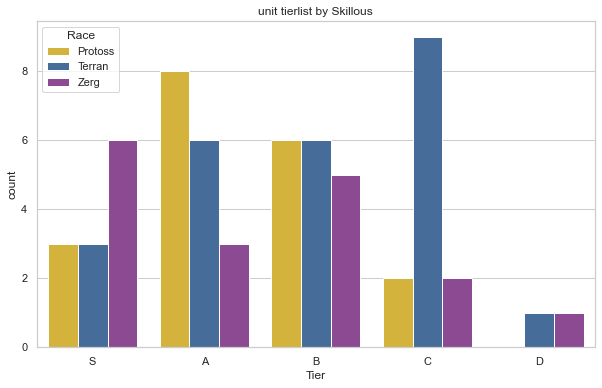

In [15]:
sns.countplot(x='Tier', hue='Race', data=df,
              order=tiers_order,
              palette=sc_race_colors)\
    .set_title('unit tierlist by Skillous');

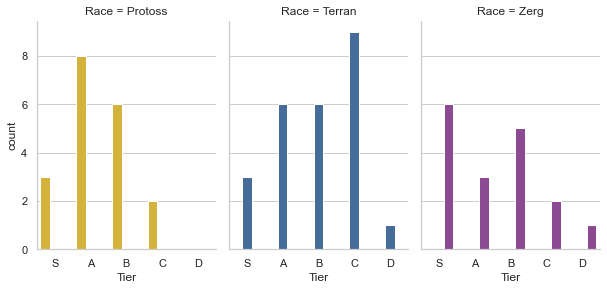

In [16]:
sns.catplot(x="Tier", hue="Race", col="Race",
            data=df, kind="count",
            order=tiers_order, palette=sc_race_colors,
            height=4, aspect=.7);

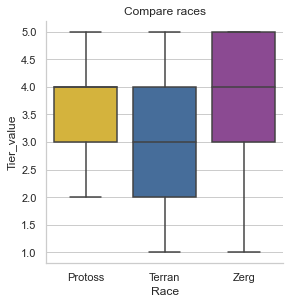

In [17]:
g = sns.catplot(x="Race", y='Tier_value',
            data=df,
            kind='box',
            palette=sc_race_colors,
            height=4)
g.ax.set_title('Compare races');

## Casters vs other units

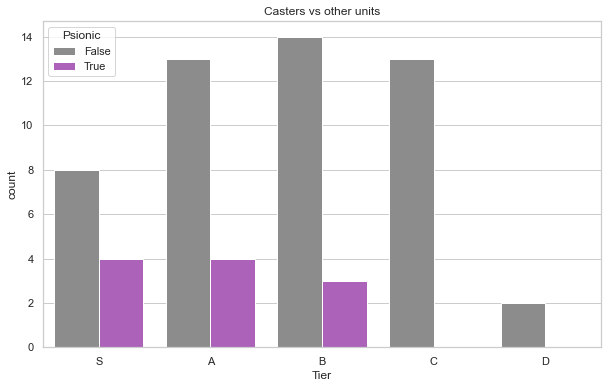

In [18]:
sns.countplot(x='Tier', hue='Psionic', data=df,
              order=tiers_order,
              palette=sc_psionic_colors)\
    .set_title('Casters vs other units');

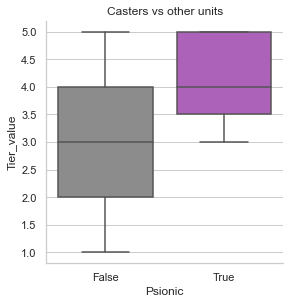

In [19]:
g = sns.catplot(x="Psionic", y='Tier_value',
            data=df,
            kind='box',
            palette=sc_psionic_colors,
            height=4)
g.ax.set_title('Casters vs other units');

## Checking dependence of the rating on other parameters

### DPS

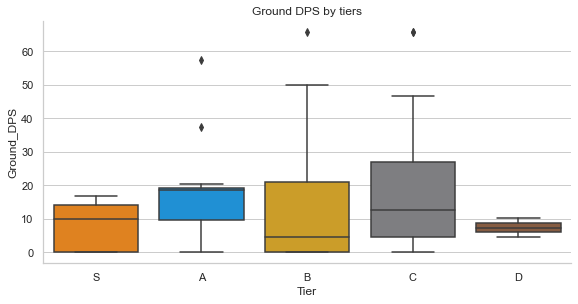

In [20]:
g = sns.catplot(x='Tier', y='Ground_DPS', order=tiers_order,
                data=df[df.Psionic == False],
                palette = tiers_colors,
                kind='box',
                height=4, aspect=2)
g.ax.set_title('Ground DPS by tiers');

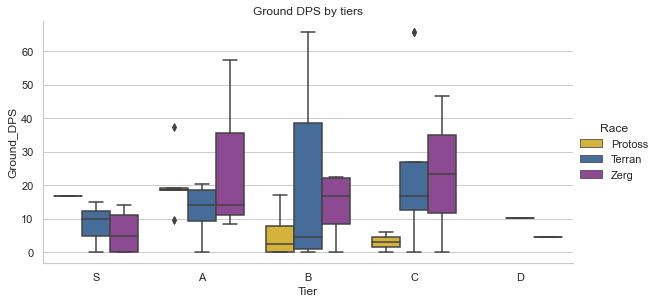

In [21]:
g = sns.catplot(x='Tier', y='Ground_DPS', order=tiers_order,
            data=df[df.Psionic == False],
            kind='box',
            hue='Race', palette=sc_race_colors,
            height=4, aspect=2)
g.ax.set_title('Ground DPS by tiers');

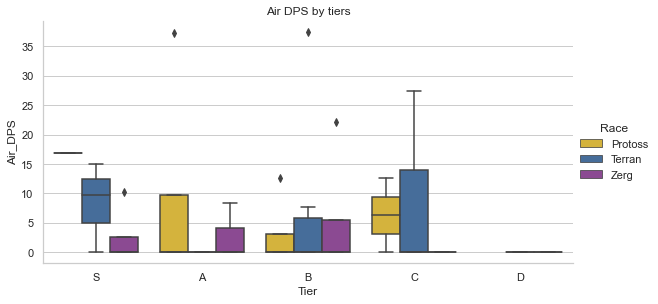

In [22]:
g = sns.catplot(x='Tier', y='Air_DPS', order=tiers_order,
            data=df[df.Psionic == False],
            kind='box',
            hue='Race', palette=sc_race_colors,
            height=4, aspect=2)
g.ax.set_title('Air DPS by tiers');

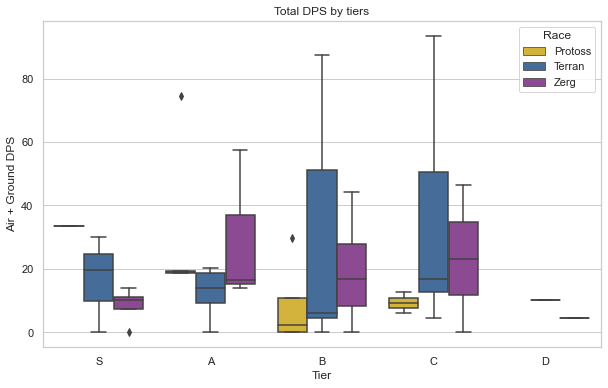

In [23]:
sns.boxplot(x=df[df.Psionic == False].Tier, order=tiers_order,
            y=df[df.Psionic == False].Air_DPS + df[df.Psionic == False].Ground_DPS,
            hue=df.Race, palette=sc_race_colors
            ).set(ylabel = 'Air + Ground DPS', title='Total DPS by tiers');

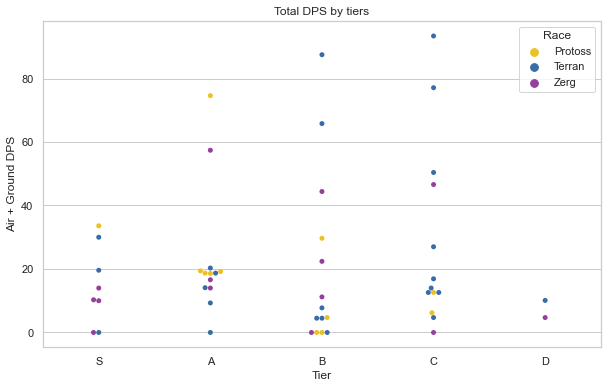

In [24]:
sns.swarmplot(x=df[df.Psionic == False].Tier, order=tiers_order,
            y=df.Air_DPS + df.Ground_DPS,
            hue=df.Race, palette=sc_race_colors
            ).set(ylabel = 'Air + Ground DPS', title='Total DPS by tiers');

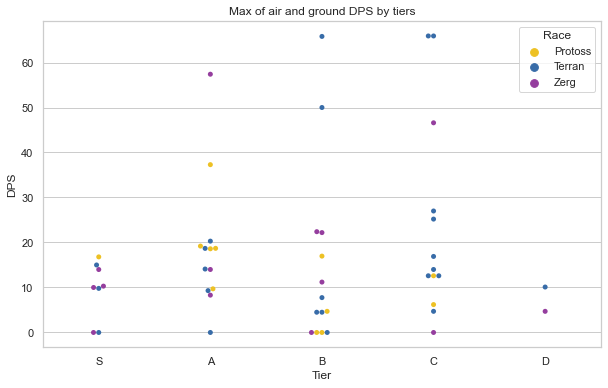

In [25]:
sns.swarmplot(x=df[df.Psionic == False].Tier, order=tiers_order,
            y=df[df.Psionic == False][['Ground_DPS','Air_DPS']].max(axis=1),
            hue=df.Race, palette=sc_race_colors
            ).set(ylabel = 'DPS', title='Max of air and ground DPS by tiers');

### Resources

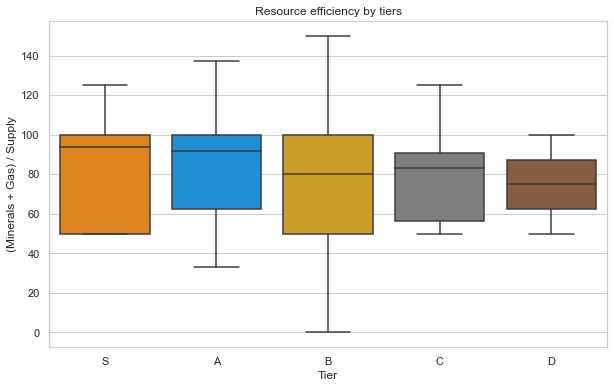

In [26]:
sns.boxplot(x=df.Tier, order=tiers_order,
            y=(df.Gas + df.Minerals) / df.Supply,
            palette = tiers_colors,
            # hue=df.Race, palette=sc_race_colors
            ).set(ylabel = '(Minerals + Gas) / Supply', title='Resource efficiency by tiers');
